In [2]:
import pandas as pd

# Load the dataset
file_path = 'Otherdata/bank-additional-full.csv'
data = pd.read_csv(file_path, delimiter=';')  # Adjusting the delimiter based on common CSV formats in banking datasets

# Display the first few rows of the dataframe and its summary
data.head(), data.info(), data.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

(   age        job  marital    education  default housing loan    contact  \
 0   56  housemaid  married     basic.4y       no      no   no  telephone   
 1   57   services  married  high.school  unknown      no   no  telephone   
 2   37   services  married  high.school       no     yes   no  telephone   
 3   40     admin.  married     basic.6y       no      no   no  telephone   
 4   56   services  married  high.school       no      no  yes  telephone   
 
   month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
 0   may         mon  ...         1    999         0  nonexistent          1.1   
 1   may         mon  ...         1    999         0  nonexistent          1.1   
 2   may         mon  ...         1    999         0  nonexistent          1.1   
 3   may         mon  ...         1    999         0  nonexistent          1.1   
 4   may         mon  ...         1    999         0  nonexistent          1.1   
 
    cons.price.idx  cons.conf.idx  euribor

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables using LabelEncoder
categorical_cols = data.select_dtypes(include=['object']).columns
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col in categorical_cols:
    data[col] = label_encoders[col].fit_transform(data[col])

# Drop the 'duration' column as it should not be included in the predictive model
data = data.drop(columns=['duration'])

# Separate features and target variable
X = data.drop('y', axis=1)
y = data['y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display shapes of the splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((32950, 19), (8238, 19), (32950,), (8238,))

In [4]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Calculate accuracy and generate a classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

accuracy, report

(0.8935421218742413,
 '              precision    recall  f1-score   support\n\n           0       0.91      0.97      0.94      7303\n           1       0.56      0.28      0.37       935\n\n    accuracy                           0.89      8238\n   macro avg       0.74      0.62      0.66      8238\nweighted avg       0.87      0.89      0.88      8238\n')

- Accuracy: 89.35%
- Precision for 'no' (0): 91% (high confidence in predicting clients not subscribing)
- Recall for 'no' (0): 97% (the model captures most of the actual 'no' cases)
- Precision for 'yes' (1): 56% (moderate confidence in predicting clients who subscribe)
- Recall for 'yes' (1): 28% (low, indicating many 'yes' cases are missed)

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define the model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define the parameter grid
param_dist = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}

# Setup the randomized search with 4-fold cross-validation
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=25, scoring='roc_auc', error_score=0, verbose=3, n_jobs=-1, cv=4)

# Fit the random search model
random_search.fit(X_train, y_train)


Fitting 4 folds for each of 25 candidates, totalling 100 fits


RandomizedSearchCV(cv=4, error_score=0,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'max_depth': [3, 4, 5, 6, 7, 8],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   scoring='roc_auc', verbose=3)

In [6]:
best_model = random_search.best_estimator_

# Now use best_model to predict and evaluate as before
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Best model accuracy:", accuracy)
print("Classification report:\n", report)


Best model accuracy: 0.8976693372177713
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      7303
           1       0.63      0.24      0.35       935

    accuracy                           0.90      8238
   macro avg       0.77      0.61      0.65      8238
weighted avg       0.88      0.90      0.88      8238



In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# Load your data and split it into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline steps
pipeline = make_pipeline(
    SMOTE(random_state=42),  # SMOTE for balancing the dataset
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
)

# Define the hyperparameters to tune
param_dist = {
    'xgbclassifier__max_depth': [3, 4, 5, 6, 7, 8],
    'xgbclassifier__min_child_weight': [1, 2, 3, 4],
    'xgbclassifier__subsample': [0.6, 0.7, 0.8, 0.9],
    'xgbclassifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}

# Setup the randomized search with 4-fold cross-validation
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=25, scoring='roc_auc', error_score=0, verbose=3, n_jobs=-1, cv=4)

# Fit the random search model
random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]  # Get probability scores for the positive class

# Calculate accuracy and generate a classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Best model accuracy:", accuracy)
print("Classification report:\n", report)



Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best model accuracy: 0.8664724447681476
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92      7303
           1       0.42      0.45      0.44       935

    accuracy                           0.87      8238
   macro avg       0.67      0.69      0.68      8238
weighted avg       0.87      0.87      0.87      8238



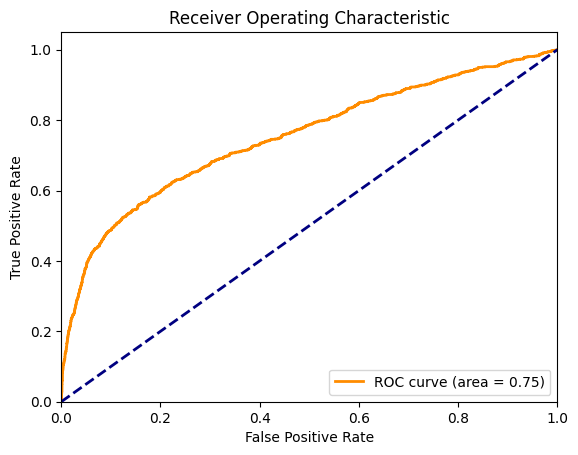

In [8]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()